In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm
from skmisc.loess import loess
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.ml.regression._kernel_regression import KernelRegression
from scipy.optimize import minimize_scalar
from scipy.interpolate import splev, interp1d
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression


# Part I: Optimal span for LOESS

In [2]:
csv_file_path = 'Coding3_Data.csv'
data_part1 = pd.read_csv(csv_file_path)
x1 = data_part1.x
y1 = data_part1.y


In [3]:
# Define a function(S_Loess) to extract the smoother matrix S from an LOESS model

def S_Loess(x, span):
    n = len(x)
    Y = np.identity(n)
    A = np.empty((n, n))
    
    for i in range(n):
        y_input = Y[:,i]
        A[:,i] = loess(x, y_input, span = span).predict(x).values
    
    S_matrix = (A + A.T)/2
    return np.diag(S_matrix)

# Define LOO-CV function for LOESS

def lcv(x, y, spans):
    
    n = len(x)
    scores = []
    for span in spans:
        errors = [] 
        
        y_fit = loess(x, y, span = span).predict(x).values
        S_diag = S_Loess(x, span)
        
        errors = ((y - y_fit) ** 2)/ ((1 - S_diag)**2)
        scores.append(np.mean(errors))
    
    return scores

# Define GCV function for LOESS

def gcv(x, y, span):
    
    n = len(x)
    scores = []
    
    for span in spans:
        errors = [] 
        
        y_fit = loess(x, y, span = span).predict(x).values
        S_diag = S_Loess(x, span)
        m = sum(S_diag)/n
        errors = ((y - y_fit) ** 2)/ ((1 - m)**2)
        scores.append(np.mean(errors))
    
    return scores



The optimal span value based on CV and GCV is 0.50


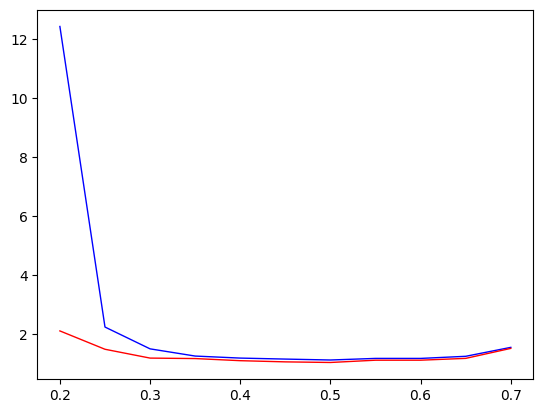

In [4]:
spans = np.arange(0.2,0.75,0.05)

LOOCV_scores = lcv(x1,y1,spans)
GCV_scores = gcv(x1,y1,spans)

loocv_min_value, loocv_min_index = min((val, idx) for idx, val in enumerate(LOOCV_scores))
gcv_min_value, gcv_min_index = min((val, idx) for idx, val in enumerate(GCV_scores))
plt.plot(spans, LOOCV_scores, color="blue", linewidth=1)
plt.plot(spans, GCV_scores, color="red", linewidth=1)

if loocv_min_index == gcv_min_index:
    print('The optimal span value based on CV and GCV is', "%.2f" % spans[loocv_min_index] )

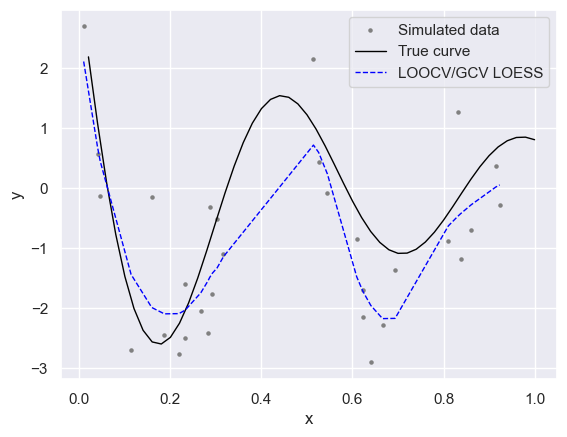

In [11]:
def f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)

fx = np.arange(1, 51, 1)/50
fy = f(fx)

sns.set()
# mpl.rcParams['figure.dpi'] = 100
plt.figure()
plt.scatter(x1, y1, color="grey", s=5, label='Simulated data')
plt.plot(fx, fy, color="black", linewidth=1, label='True curve')
if loocv_min_index == gcv_min_index:
    span_opt = spans[loocv_min_index]
    smoothing_opt = loess(x1, y1, span = span_opt).predict(x1).values
    plt.plot(x1, smoothing_opt, linestyle='--', color="blue", linewidth=1, label='LOOCV/GCV LOESS')
else:
    span_lcv = spans[loocv_min_index]
    span_gcv = spans[gcv_min_index]
    smoothing_lcv = loess(x1, y1, span = span_lcv).predict(x1).values
    smoothing_gcv = loess(x1, y1, span = span_gcv).predict(x1).values
    plt.plot(x1, smoothing_lcv,linestyle='--', color="blue", linewidth=1, label='LOO-CV LOESS')
    plt.plot(x1, smoothing_gcv,linestyle='--', color="red", linewidth=1, label='GCV LOESS')
    
plt.legend()    
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Part II: Clustering time series

In [12]:
# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis
    

In [13]:
csv_file_path2 = 'Sales_Transactions_Dataset_Weekly.csv'
data_part2 = pd.read_csv(csv_file_path2)

weeks_idx = data_part2.columns[1:53]
x2_before = data_part2.iloc[:,1:53]
x2_mean = x2_before.mean(axis = 1)
x2 = x2_before.sub(x2_mean, axis=0)
x2.shape

(811, 52)

In [14]:
np.random.seed(2417)

nrow = x2.shape[0]
B = np.empty((nrow, 9))
ncs_fitted_values = pd.DataFrame()
week = np.arange(0,52)

x_ncs = ns(week,df = 10)

for i in range(nrow):
    
    y_ncs = x2.loc[i].values  
    ncs_model = LinearRegression().fit(x_ncs, y_ncs)
    ncs_coeff = ncs_model.coef_[1:]
    B[i, :] = ncs_coeff


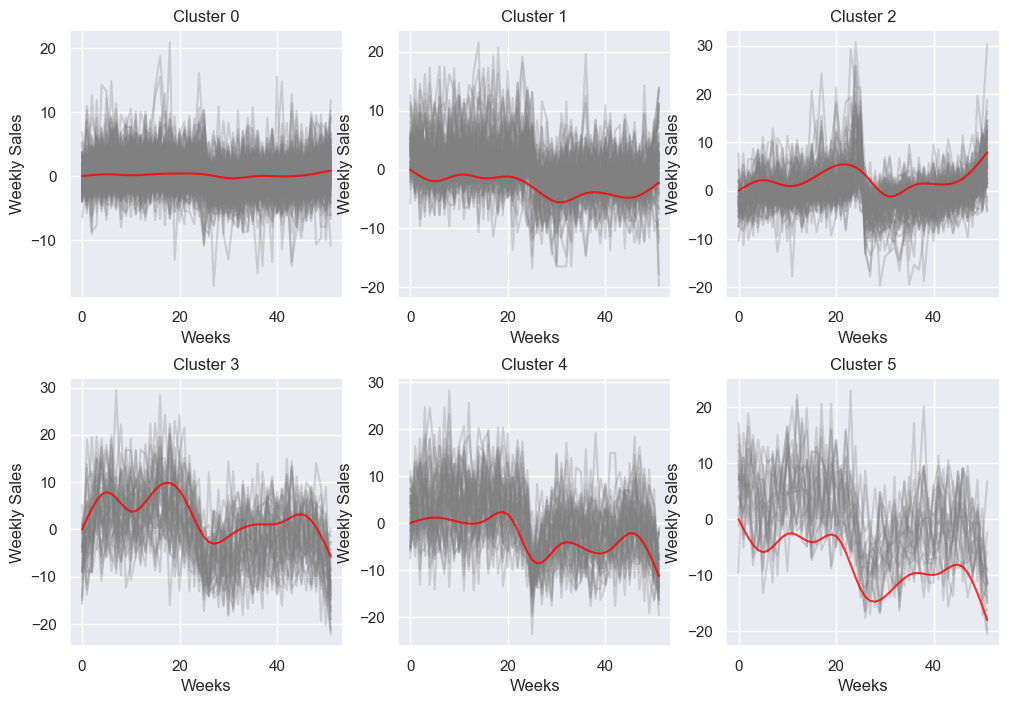

In [15]:
n_clusters = 6

kmeans = KMeans(n_clusters = n_clusters, random_state=0)
kmeans.fit(B)

cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)

for icluster in range(n_clusters):
    
    cluster_idx = np.where(cluster_labels == icluster)[0]
    ax = axes[icluster // 3, icluster % 3]
    
    for idx in cluster_idx:
        ax.plot(week, x2.iloc[idx], color='grey',alpha=0.3, linewidth=1.5)
        
    b = cluster_centers[icluster,:]
    F = x_ncs[:,1:]
    y_plot = np.dot(F, b)
    ax.plot(week, y_plot, color='red', alpha=0.8)

    # Plot cluster center (red)

    ax.set_title(f'Cluster {icluster}')
    ax.set_xlabel('Weeks')
    ax.set_ylabel('Weekly Sales')
  
    

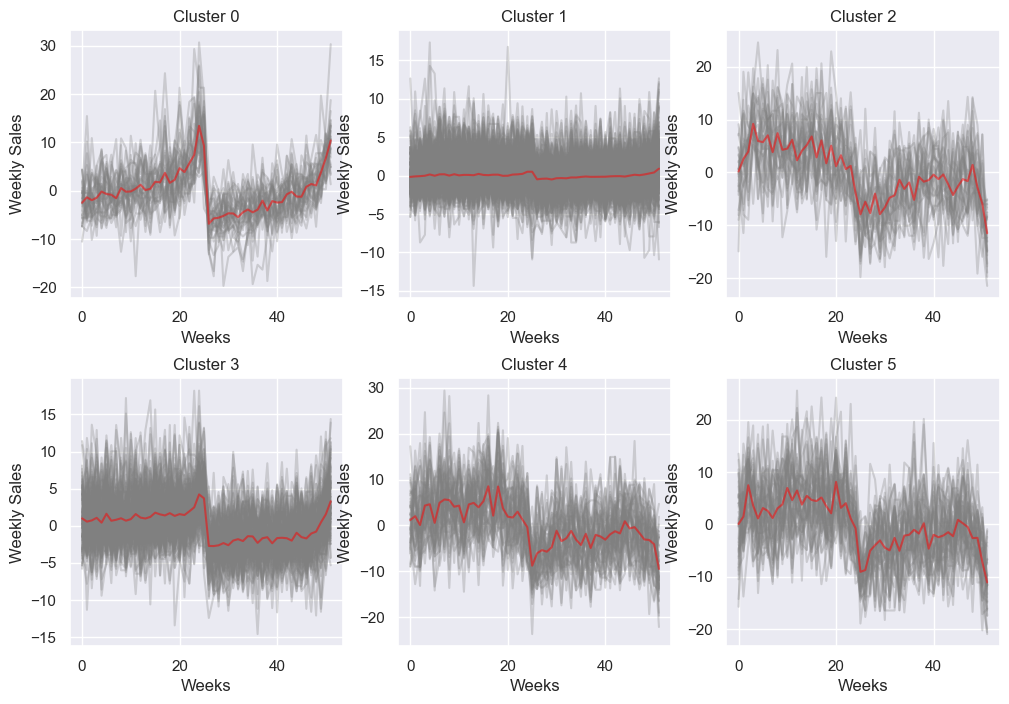

In [16]:
x2_np = x2.values

kmeans_x = KMeans(n_clusters = n_clusters, random_state=0)
kmeans_x.fit(x2_np)

cluster_labels_x= kmeans_x.labels_
cluster_centers_x = kmeans_x.cluster_centers_

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)

F = x_ncs[:,1:]

for icluster in range(n_clusters):
    
    cluster_idx = np.where(cluster_labels_x == icluster)[0]
    ax = axes[icluster // 3, icluster % 3]
    
    for idx in cluster_idx:
        ax.plot(week, x2_np[idx,:], color='grey', alpha=0.3,linewidth=1.5)
        
    y_plot = cluster_centers_x[icluster,:]
    ax.plot(week, y_plot, color='red', alpha=0.5)

    ax.set_title(f'Cluster {icluster}')
    ax.set_xlabel('Weeks')
    ax.set_ylabel('Weekly Sales')

# Part III: Ridgeless and double descent

### Task 1: Ridgeless Function

In [17]:

def ridgeless_pca(train_data, test_data, eps): 

    train_X_ori = train_data[:,1:]
    train_Y = train_data[:,0]
    
    test_X_ori = test_data[:,1:]
    test_Y = test_data[:,0]
    
    train_X = train_X_ori - np.mean(train_X_ori, axis = 0)
    test_X = test_X_ori - np.mean(test_X_ori, axis = 0) 

    U, S, V = np.linalg.svd(train_X) #, full_matrices = True)

    stable_idx = np.where(S >= eps)[0]# remove the extremely small eigenvalues
    V_stable = V[stable_idx,:]
    
    train_X_PCA = np.dot(train_X, V_stable.T)
    train_X_PCA_T = train_X_PCA.T
    
    beta_1 = np.linalg.inv(np.dot(train_X_PCA_T, train_X_PCA)) 
    beta_2 = np.dot(beta_1,train_X_PCA_T)
#     np.dot(train_X_PCA_T, train_Y)
#     print(np.dot(train_X_PCA_T, train_X_PCA))
    beta = np.dot(beta_2,train_Y)

    train_predict = np.dot(train_X_PCA, beta)
#     train_error = sum((train_Y - train_predict)**2)/train_Y.shape[0]
    train_error = np.sqrt(np.mean((train_Y - train_predict ) ** 2))
    
    test_X_PCA = np.dot(test_X, V_stable.T)
#     train_X_PCA = np.dot(np.dot(test_X.T, V_stable), np.diag(S[stable_idx]))

    test_predict = np.dot(test_X_PCA, beta)
#     test_error = sum((test_Y - test_predict)**2)/test_Y.shape[0]
    test_error = np.sqrt(np.mean((test_Y - test_predict ) ** 2))
    return train_error, test_error

### Task 2: Simulation study

In [18]:
csv_file_path3 = 'Coding3_dataH.csv'
data_part3 = pd.read_csv(csv_file_path3).values

T = 30

d_range = np.arange(6,242,1)
errors = np.empty((T,len(d_range)))

for kk in tqdm(range(T)):
    irow = kk
    jcol = 0
    for dd in range(6,242):
        data_all = data_part3[:,0:dd]
        train_data, test_data = train_test_split(data_all, test_size=0.75)
        train_error, test_error = ridgeless_pca(train_data, test_data, eps=1e-10)
        errors[irow,jcol]  = math.log10(test_error)
        jcol = jcol+1
        


100%|███████████████████████████████████████████| 30/30 [00:25<00:00,  1.18it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

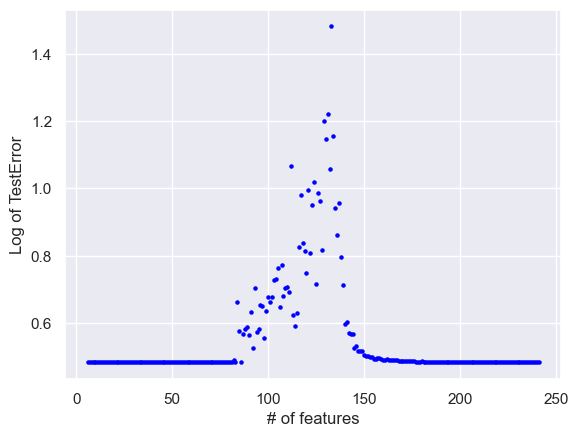

In [19]:
error_mean = errors.mean(axis = 0)
plt.figure()
plt.scatter(d_range, error_mean, color = 'blue',s = 5)
plt.xlabel("# of features")
plt.ylabel("Log of TestError")
plt.show